In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

c:\Users\13410\.conda\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Tensorflow V2.6.0
Keras V2.6.0
Python V3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]


In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

In [3]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
##IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
##VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

In [4]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

In [5]:
train = pd.read_csv('dataset/train.csv').sample(int(5e3), random_state=SEED)



N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 5000


In [6]:
def get_file_path(path):
    return f'dataset/{path}'

train['file_path'] = train['path'].apply(get_file_path)

In [7]:
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [8]:
display(train.head(30))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
56533,train_landmark_files/28656/3311214787.parquet,28656,3311214787,sticky,dataset/train_landmark_files/28656/3311214787....,206
63119,train_landmark_files/53618/3588192588.parquet,53618,3588192588,before,dataset/train_landmark_files/53618/3588192588....,20
8760,train_landmark_files/4718/1363575346.parquet,4718,1363575346,pretty,dataset/train_landmark_files/4718/1363575346.p...,178
93310,train_landmark_files/37779/951199059.parquet,37779,951199059,hen,dataset/train_landmark_files/37779/951199059.p...,114
44842,train_landmark_files/36257/283190141.parquet,36257,283190141,tomorrow,dataset/train_landmark_files/36257/283190141.p...,221
20993,train_landmark_files/61333/186594661.parquet,61333,186594661,up,dataset/train_landmark_files/61333/186594661.p...,230
89267,train_landmark_files/53618/782770724.parquet,53618,782770724,blow,dataset/train_landmark_files/53618/782770724.p...,25
48370,train_landmark_files/16069/2977903115.parquet,16069,2977903115,weus,dataset/train_landmark_files/16069/2977903115....,236
41330,train_landmark_files/2044/269101282.parquet,2044,269101282,read,dataset/train_landmark_files/2044/269101282.pa...,184
53090,train_landmark_files/28656/3171133897.parquet,28656,3171133897,say,dataset/train_landmark_files/28656/3171133897....,191


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 56533 to 19516
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            5000 non-null   object
 1   participant_id  5000 non-null   int64 
 2   sequence_id     5000 non-null   int64 
 3   sign            5000 non-null   object
 4   file_path       5000 non-null   object
 5   sign_ord        5000 non-null   int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 244.1+ KB


None

In [10]:
N = int(1e3)
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

for idx, file_path in enumerate(tqdm(train['file_path'].sample(N, random_state=SEED))):
    ##print(file_path)
    df = pd.read_parquet(file_path)
    N_UNIQUE_FRAMES[idx] = df['frame'].nunique()
    N_MISSING_FRAMES[idx] = (df['frame'].max() - df['frame'].min()) - df['frame'].nunique() + 1
    MAX_FRAME[idx] = df['frame'].max()

100%|██████████| 1000/1000 [00:07<00:00, 136.45it/s]


,N_UNIQUE_FRAMES
count,1000.000000
mean,37.676000
std,46.188184
min,4.000000
1%,6.000000
5%,6.000000
25%,11.000000
50%,21.000000
75%,43.000000
95%,139.050000


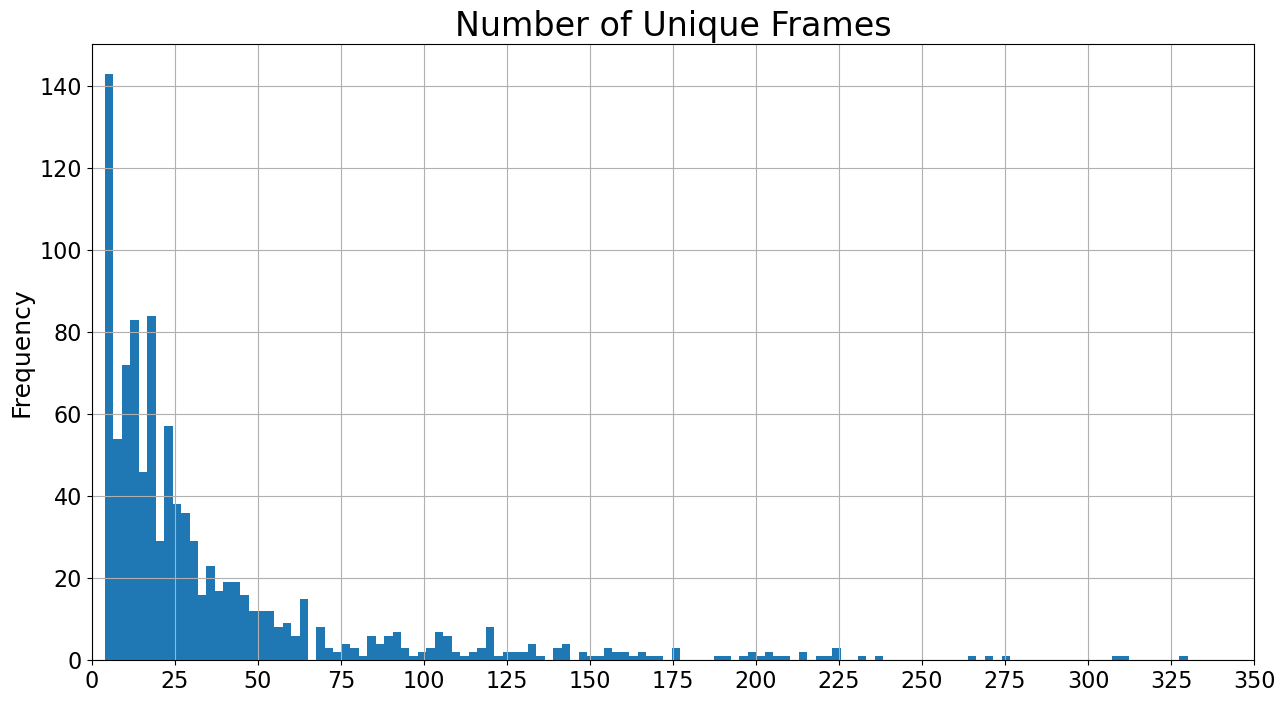

In [11]:
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_UNIQUE_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

,N_MISSING_FRAMES
count,1000.000000
mean,0.001000
std,0.031623
min,0.000000
1%,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
95%,0.000000


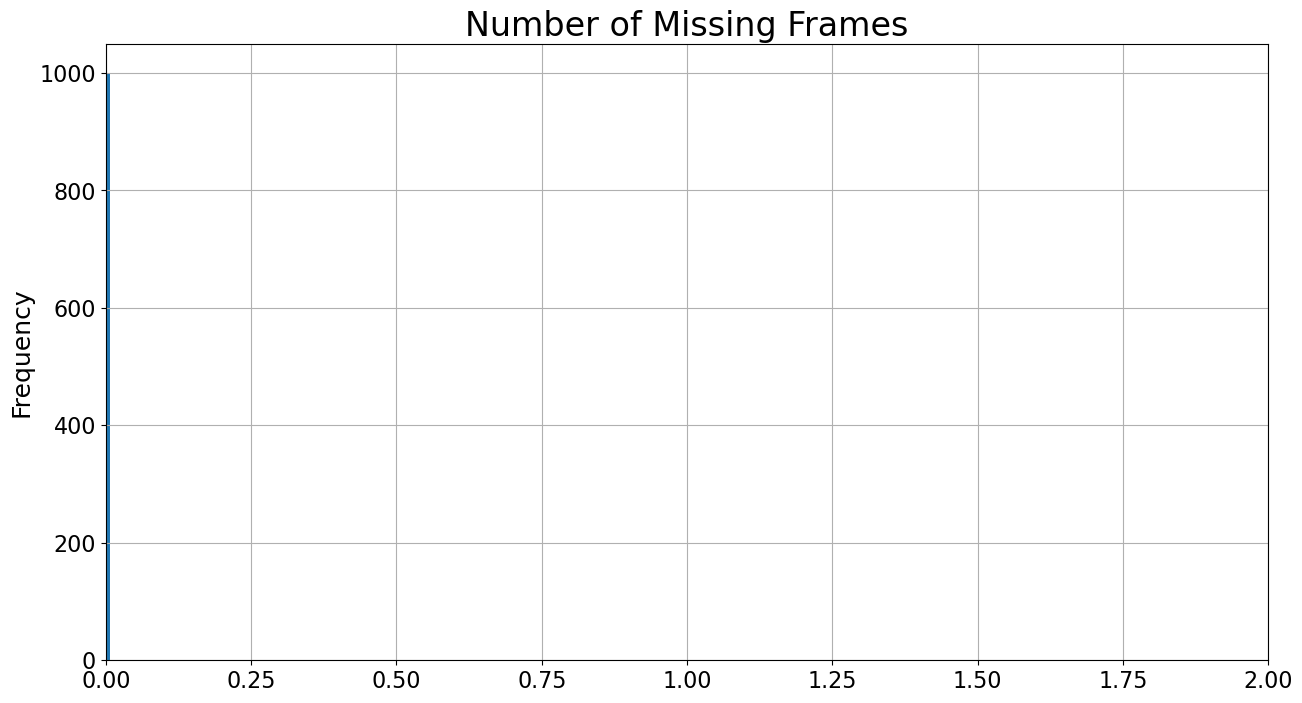

In [12]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
display(pd.Series(N_MISSING_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_MISSING_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(N_MISSING_FRAMES).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

,MAX_FRAME
count,1000.000000
mean,66.761000
std,59.679222
min,3.000000
1%,12.990000
5%,22.000000
25%,33.000000
50%,42.000000
75%,61.000000
95%,203.050000


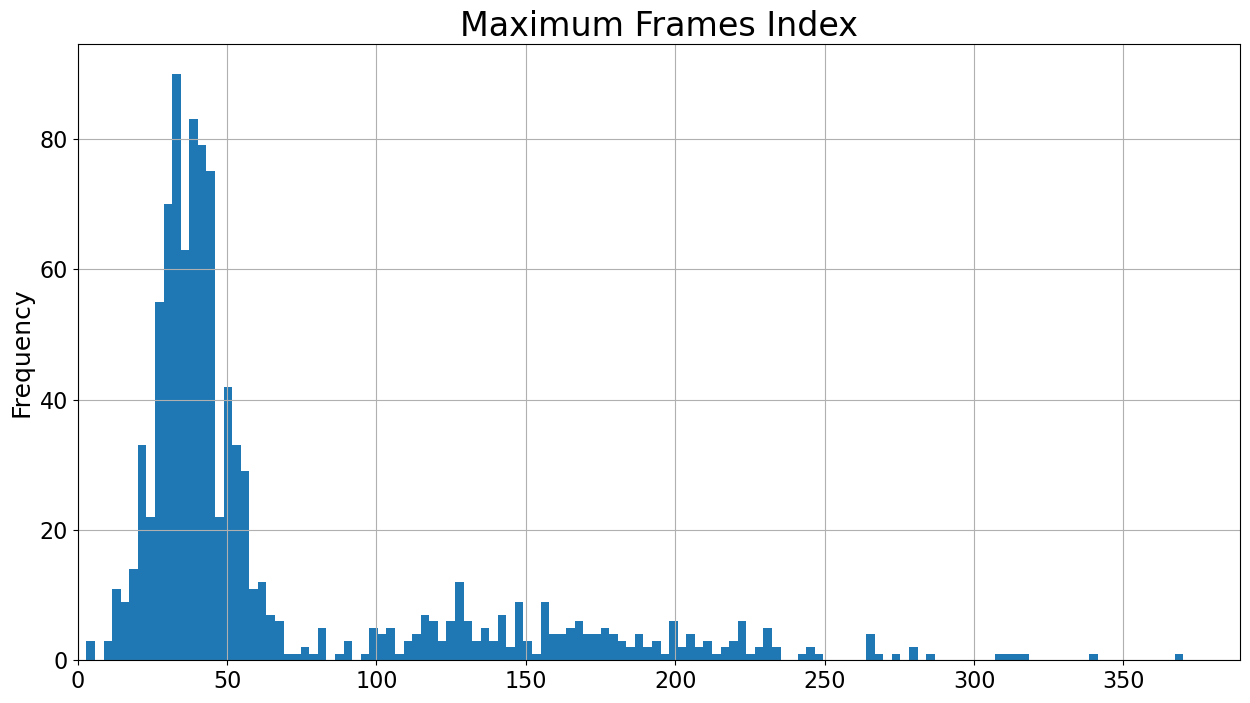

In [13]:
# Maximum frame number
display(pd.Series(MAX_FRAME).describe(percentiles=PERCENTILES).to_frame('MAX_FRAME'))

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(MAX_FRAME).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

In [14]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66
